<a href="https://colab.research.google.com/github/mahdiSheykhiGithub/Houses-prices/blob/main/Houses_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from glob import glob
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Concatenate, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn import metrics

# Preprocessing

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Houses Price/Houses Dataset/'

**table Data**

In [ ]:
data_tab_path = '/content/drive/MyDrive/Colab Notebooks/Houses Price/Houses Dataset/HousesInfo.txt'
columns_name = ['Bedrooms', 'Bathrooms', 'Area', 'Zipcode', 'Price']
data_tab = pd.read_csv(data_tab_path, names = columns_name, sep=' ')

In [ ]:
data_tab.head()

,Bedrooms,Bathrooms,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [ ]:
data_tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bedrooms   535 non-null    int64  
 1   Bathrooms  535 non-null    float64
 2   Area       535 non-null    int64  
 3   Zipcode    535 non-null    int64  
 4   Price      535 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 21.0 KB


In [ ]:
data_tab.Zipcode.unique().shape

(49,)

In [ ]:
np.unique(data_tab.Zipcode, return_counts=True)

(array([36372, 60002, 60016, 60046, 62025, 62034, 62088, 62214, 62234,
        62249, 81418, 81521, 81524, 85255, 85262, 85266, 85331, 85377,
        90038, 90211, 90265, 90803, 91752, 91901, 91915, 92021, 92040,
        92253, 92276, 92543, 92677, 92692, 92802, 92880, 93105, 93111,
        93314, 93446, 93510, 93720, 93924, 94501, 94531, 94565, 94568,
        95008, 95220, 96019, 98021]),
 array([  1,   3,   2,   1,   2,   1,   1,   4,   7,   1,   2,   1,  11,
         12,   9,  11,   1,   3,   1,   1,   1,   1,   3,  32,   1,  11,
          1,   2, 100,   1,  26,   2,   9,  49,   1,  11,   1,  54,  60,
          1,   1,  41,  22,   1,   1,   1,  10,  12,   4]))

In [ ]:
zip_counts = np.unique(data_tab.Zipcode, return_counts=True)[1]
zip_code = np.unique(data_tab.Zipcode, return_counts=True)[0]

In [ ]:
zip_counts[zip_counts >= 9].shape

(17,)

In [ ]:
for i,j in zip(zip_code, zip_counts):
  if j < 9 :
    data_tab.loc[data_tab.Zipcode == i, 'Zipcode'] = 0

In [ ]:
np.unique(data_tab.Zipcode, return_counts=True)

(array([    0, 81524, 85255, 85262, 85266, 91901, 92021, 92276, 92677,
        92802, 92880, 93111, 93446, 93510, 94501, 94531, 95220, 96019]),
 array([ 55,  11,  12,   9,  11,  32,  11, 100,  26,   9,  49,  11,  54,
         60,  41,  22,  10,  12]))

In [ ]:
ohe = OneHotEncoder()
zipcode_encode = ohe.fit_transform(data_tab.Zipcode.values.reshape(-1, 1)).toarray()

In [ ]:
zipcode_encode.shape

(535, 18)

In [ ]:
scaler = StandardScaler()
data_tab_scaled = scaler.fit_transform(data_tab[['Bedrooms', 'Bathrooms', 'Area']])

In [ ]:
max_price = data_tab.Price.max()
price = data_tab.Price / max_price

In [ ]:
data_tab = np.concatenate([data_tab_scaled, zipcode_encode], axis=1)

In [ ]:
data_tab.shape

(535, 21)

**Image Data**

In [ ]:
data_img = []

for i in range(1,len(data_tab) + 1):
  img_path = glob(dataset_path + f'{i}_*.jpg')
  img_path.sort()
  img_list = []
  for path in img_path:
    img = cv2.imread(path)
    img = cv2.resize(img, (64,64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_list.append(img)

  img_combo = np.zeros([128,128,3])

  img_combo[0:64,0:64] = img_list[0]
  img_combo[0:64,64:128] = img_list[1]
  img_combo[64:128,0:64] = img_list[2]
  img_combo[64:128,64:128] = img_list[3]

  data_img.append(img_combo)

In [ ]:
data_img = np.array(data_img) / 255

In [ ]:
data_img.shape

(535, 128, 128, 3)

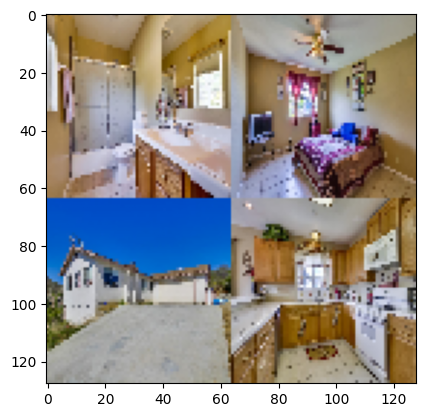

In [ ]:
plt.imshow(data_img[100])
plt.show()

In [ ]:
X_tab_train = data_tab[:435]
X_tab_test = data_tab[435:]

X_img_train = data_img[:435]
X_img_test = data_img[435:]

y_train = price[:435]
y_test = price[435:]

# Modeling

In [ ]:
# table data channel
input_layer_ch1 = Input(shape = (21,))
dense_layer1_ch1 = Dense(units = 128, activation = 'relu')(input_layer_ch1)
dp = Dropout(0.45)(dense_layer1_ch1)
dense_layer2_ch1 = Dense(units = 128, activation = 'relu')(dp)
# image data channel
input_layer_ch2 = Input(shape = (128,128,3))
conv_layer1_ch2 = Conv2D(16, (3,3), activation='relu')(input_layer_ch2)
dp = Dropout(0.3)(conv_layer1_ch2)
maxpool1_ch2 = MaxPool2D()(dp)
conv_layer2_ch2 = Conv2D(32, (3,3), activation='relu')(maxpool1_ch2)
dp = Dropout(0.3)(conv_layer2_ch2)
maxpool2_ch2 = MaxPool2D()(dp)
flatten = Flatten()(maxpool2_ch2)
# concatenate channels outputs
concat = Concatenate()([dense_layer2_ch1, flatten])

output_layer = Dense(1, activation='linear')(concat)


In [ ]:
model = Model(inputs=[input_layer_ch1, input_layer_ch2], outputs=[output_layer])

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 126, 126, 16)         448       ['input_22[0][0]']            
                                                                                                  
 dropout_25 (Dropout)        (None, 126, 126, 16)         0         ['conv2d_20[0][0]']           
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 63, 63, 16)           0         ['dropout_25[0][0]']          
 ng2D)                                                                                      

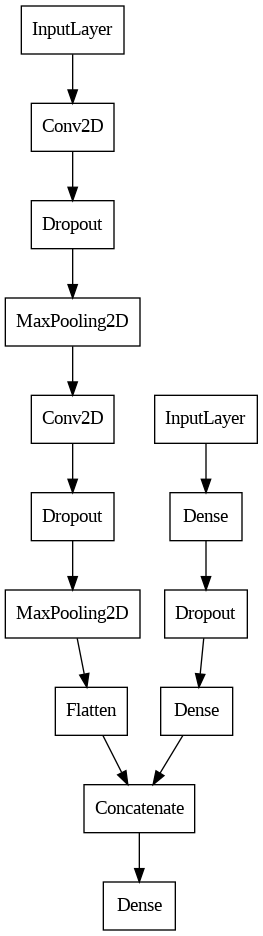

In [ ]:
plot_model(model, show_layer_names=False)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.001)
loss = tf.losses.MeanAbsoluteError()

model.compile(optimizer = opt, loss = loss)

In [ ]:
model.fit([X_tab_train, X_img_train], y_train, epochs=100, validation_data=[[X_tab_test, X_img_test],y_test], verbose=2)

Epoch 1/100
14/14 - 7s - loss: 0.8685 - val_loss: 0.0369 - 7s/epoch - 499ms/step
Epoch 2/100
14/14 - 7s - loss: 0.0717 - val_loss: 0.0475 - 7s/epoch - 518ms/step
Epoch 3/100
14/14 - 6s - loss: 0.0521 - val_loss: 0.0513 - 6s/epoch - 460ms/step
Epoch 4/100
14/14 - 7s - loss: 0.0455 - val_loss: 0.0409 - 7s/epoch - 515ms/step
Epoch 5/100
14/14 - 6s - loss: 0.0404 - val_loss: 0.0325 - 6s/epoch - 402ms/step
Epoch 6/100
14/14 - 7s - loss: 0.0373 - val_loss: 0.0336 - 7s/epoch - 470ms/step
Epoch 7/100
14/14 - 6s - loss: 0.0338 - val_loss: 0.0289 - 6s/epoch - 446ms/step
Epoch 8/100
14/14 - 6s - loss: 0.0326 - val_loss: 0.0337 - 6s/epoch - 425ms/step
Epoch 9/100
14/14 - 7s - loss: 0.0302 - val_loss: 0.0321 - 7s/epoch - 495ms/step
Epoch 10/100
14/14 - 6s - loss: 0.0303 - val_loss: 0.0331 - 6s/epoch - 403ms/step
Epoch 11/100
14/14 - 7s - loss: 0.0283 - val_loss: 0.0307 - 7s/epoch - 525ms/step
Epoch 12/100
14/14 - 6s - loss: 0.0278 - val_loss: 0.0307 - 6s/epoch - 400ms/step
Epoch 13/100
14/14 - 7s -

In [ ]:
y_pred = model.predict([X_tab_test, X_img_test])

4/4 [==============================] - 1s 148ms/step


In [ ]:
y_pred.shape

(100, 1)

In [ ]:
metrics.mean_absolute_error(y_pred , y_test)

0.0233219252691319